Reddit Scrape

In [1]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [2]:
import praw

# Reddit API 
reddit = praw.Reddit(
    client_id='PiX5OOgasCP_mtmS2JjUrg',  # client_id
    client_secret='Yjc8QGuRvTsX_sPyJj92RwkBMM0xpA',  # client_secret
    user_agent='stacy5067'  # user_agent
)

import csv
from datetime import datetime

subreddit_name = 'electricvehicles'
subreddit = reddit.subreddit(subreddit_name)

with open('reddit_posts.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Title', 'Content', 'Date'])

    post_count = 0
    num_posts= 1000

    for submission in subreddit.new(limit=num_posts):
        post_date = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
        writer.writerow([submission.id, submission.title, submission.selftext, post_date])
        post_count += 1

print(f"Data has been saved to 'reddit_posts.csv'. Total posts: {post_count}")

subreddit_name = 'electriccars'
subreddit = reddit.subreddit(subreddit_name)

with open('relectriccars.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Title', 'Content', 'Date'])

    for submission in subreddit.new(limit=num_posts):
        post_date = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')  
        writer.writerow([submission.id, submission.title, submission.selftext, post_date])
        post_count += 1  

print(f"Data has been saved to 'relectriccars.csv'. Total posts: {post_count}")

Data has been saved to 'reddit_posts.csv'. Total posts: 986
Data has been saved to 'relectriccars.csv'. Total posts: 1879


Merge 

In [3]:
import pandas as pd

df1 = pd.read_csv("reddit_posts.csv")
df2 = pd.read_csv("relectriccars.csv")

df_merged = pd.concat([df1, df2], ignore_index=True)

df_merged.to_csv("merged_reddit_posts.csv", index=False)


Data Analysis

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import download
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
import numpy as np

download('punkt')
download('stopwords')
download('wordnet')


[nltk_data] Downloading package punkt to /Users/stacytsai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stacytsai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stacytsai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
data = pd.read_csv('merged_reddit_posts.csv')
data['Text'] = data['Title'] + ' ' + data['Content'].fillna('')  
data.drop_duplicates(subset='ID', keep='first', inplace=True)
data = data[~data['Text'].str.contains("weekly roundup for week of")]
text_lengths = data['Text'].apply(len)  
text_stats = text_lengths.describe()  

print("Descriptive statistics for text length：")
print(text_stats)

num_texts = len(data['Text'])
print(f"There are a total of {num_texts} texts")

Descriptive statistics for text length：
count     1862.000000
mean       428.641783
std        962.459368
min          4.000000
25%         66.000000
50%        133.000000
75%        482.000000
max      24446.000000
Name: Text, dtype: float64
There are a total of 1862 texts


In [6]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

data['Cleaned_Text'] = data['Text'].apply(clean_text)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = ['ev', 'vehicle', 'car', 'im', 'wa', 'ha', 'dont', 'u', 'doe',
                     'ive', 'id', 'v', 'doesnt', 'cant', 'hi', 'isnt', 'k', 'wont', 'le', 
                     'e', 'r', 'wouldnt', 'youre', 'x', 'hello', 'couldnt', 'arent', 
                     'wasnt', 'hey', 'l', 'f', 'q', 'st', 'lol', 'n', 'c', 'th', 
                     'would', 'could', 'didnt', 'j', 'b', 'w', 'etc', 'whats',
                     'one', 'two', 'three', 'weve', 'ok', 'okay','ea','mi','ex','h', 'p', 'g','na', 'thanks',
                     'also', 'may', 'thats', 'might','done','thank', 'must','need','people']

stop_words.update(custom_stop_words)

def tokenize_and_lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    filtered_words = [word for word in lemmatized_words if word not in stop_words]
    return filtered_words
data['Processed_Text'] = data['Cleaned_Text'].apply(tokenize_and_lemmatize)
dictionary = corpora.Dictionary(data['Processed_Text'])
dictionary.filter_extremes(no_below=10, no_above=0.35, keep_n=10000)
corpus = [dictionary.doc2bow(text) for text in data['Processed_Text']]

In [7]:
original_word_list = [word for text in data['Cleaned_Text'] for word in text.split()]
cleaned_word_list = [word for text in data['Processed_Text'] for word in text]

# Display the first 100 words before cleaning
print("First 100 words before cleaning:", original_word_list[:100])

# Display the first 100 words after cleaning
print("First 100 words after cleaning:", cleaned_word_list[:100])

# Display the total number of words before and after cleaning
print("Total number of words before cleaning:", len(original_word_list))
print("Total number of words after cleaning:", len(cleaned_word_list))

First 100 words before cleaning: ['byd', 'sells', 'record', 'cars', 'in', 'aug', 'phevs', 'hit', 'th', 'consecutive', 'month', 'of', 'record', 'sales', 'instead', 'of', 'each', 'manufacturer', 'having', 'proprietary', 'batteries', 'what', 'if', 'we', 'had', 'batteries', 'of', 'different', 'sizes', 'that', 'could', 'suit', 'the', 'needs', 'of', 'multiple', 'cars', 'when', 'you', 'need', 'more', 'juice', 'pull', 'into', 'a', 'battery', 'bank', 'a', 'robot', 'unhooks', 'the', 'depleted', 'battery', 'and', 'puts', 'in', 'a', 'new', 'one', 'basically', 'the', 'title', 'but', 'this', 'would', 'cut', 'down', 'on', 'charging', 'time', 'and', 'would', 'make', 'roadtrips', 'or', 'hauling', 'viable', 'the', 'charging', 'bank', 'for', 'the', 'batteries', 'would', 'also', 'be', 'able', 'to', 'access', 'the', 'health', 'of', 'individual', 'cells', 'just', 'like', 'a', 'gas', 'station', 'youd']
First 100 words after cleaning: ['byd', 'sell', 'record', 'aug', 'phevs', 'hit', 'consecutive', 'month', 'r

In [8]:
# Define a function to display text before and after cleaning
def display_original_and_processed(text):
    # Clean the text
    cleaned_text = clean_text(text)
    # Tokenize and lemmatize
    processed_words = tokenize_and_lemmatize(cleaned_text)
    # Display results
    print("Original text:", text)
    print("Cleaned text:", cleaned_text)
    print("Text after tokenization and lemmatization:", processed_words)

# Example text
example_text = data['Text'].iloc[290]
display_original_and_processed(example_text)

word_freq = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)[:30]
for word_id, freq in word_freq:
    print(f'Word: {dictionary[word_id]}, Frequency: {freq}')

Original text: Ford says a pickup truck will be the first EV built on its low-cost platform 
Cleaned text: ford says a pickup truck will be the first ev built on its lowcost platform 
Text after tokenization and lemmatization: ['ford', 'say', 'pickup', 'truck', 'first', 'built', 'lowcost', 'platform']
Word: electric, Frequency: 441
Word: charging, Frequency: 351
Word: tesla, Frequency: 318
Word: charger, Frequency: 271
Word: like, Frequency: 269
Word: get, Frequency: 258
Word: new, Frequency: 255
Word: battery, Frequency: 241
Word: charge, Frequency: 226
Word: time, Frequency: 188
Word: know, Frequency: 179
Word: model, Frequency: 176
Word: drive, Frequency: 175
Word: year, Frequency: 174
Word: first, Frequency: 169
Word: range, Frequency: 168
Word: mile, Frequency: 157
Word: anyone, Frequency: 155
Word: looking, Frequency: 151
Word: make, Frequency: 146
Word: used, Frequency: 141
Word: home, Frequency: 140
Word: use, Frequency: 133
Word: work, Frequency: 132
Word: think, Frequency: 13

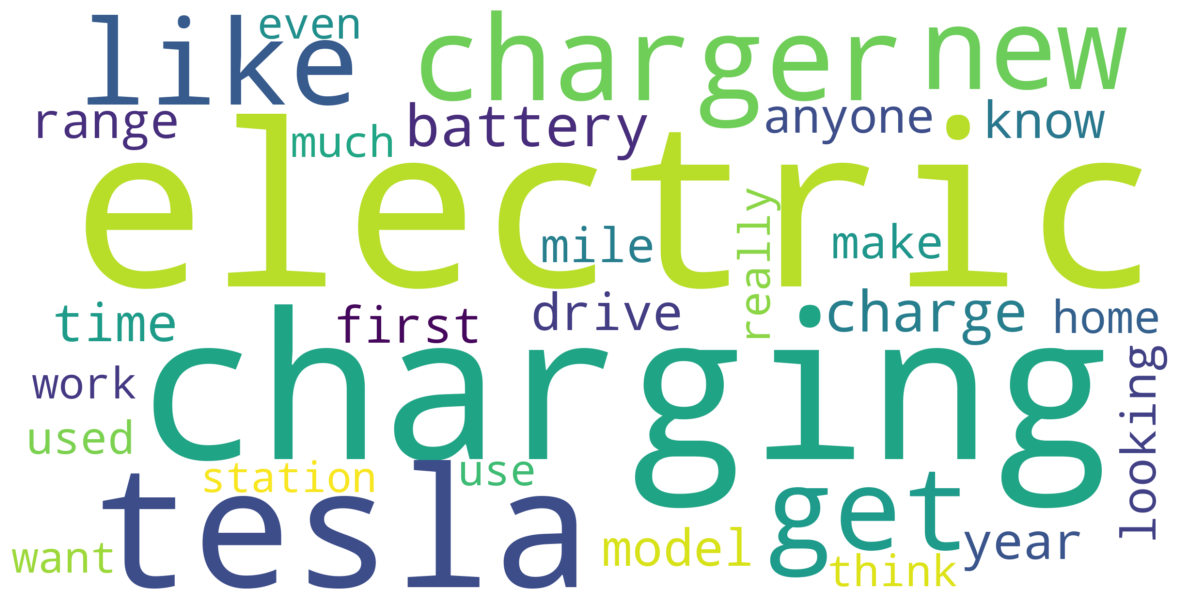

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq_dict = {dictionary[word_id]: freq for word_id, freq in word_freq}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=300,            
    min_font_size=10,         
    scale=3,                  
    stopwords=stop_words      
).generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()


In [10]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity_values.append(np.exp(model.log_perplexity(corpus)))
    return model_list, coherence_values, perplexity_values

start, limit, step = 2, 11, 1  
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary, corpus, data['Processed_Text'], start, limit, step)


x = range(start, limit, step)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Topic Coherence Metrics")

plt.subplot(1, 2, 2)
plt.plot(x, perplexity_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.title("Topic Perplexity Metrics")

plt.tight_layout()
plt.show()


In [ ]:
num_topics = 5
start = 2  

index = num_topics - start 

coherence_score = coherence_values[index]
perplexity_score = perplexity_values[index]

print(f"Coherence Score at {num_topics} topics: {coherence_score}")
print(f"Perplexity Score at {num_topics} topics: {perplexity_score}")

In [ ]:
# Train the final LDA model
final_lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Print each topic and its keywords
for idx, topic in final_lda_model.print_topics(num_words=20):
    print(f'Topic: {idx} \nKeywords: {topic}')

# Analyze the main topic of each document
topic_counts = [0] * num_topics  # Initialize a counter based on the number of topics
for doc_bow in corpus:
    topics = final_lda_model.get_document_topics(doc_bow)
    # Calculate the main topic index for each document (no need to adjust the index)
    main_topic = max(topics, key=lambda x: x[1])[0]
    # Direct counting
    topic_counts[main_topic] += 1

# Calculate the total number of documents and the proportion of each topic
total_docs = len(corpus)
topic_proportions = [count / total_docs for count in topic_counts]

print("Topic Counts:", topic_counts)
print("Topic Proportions:", topic_proportions)

In [ ]:
from collections import Counter
from wordcloud import WordCloud

for idx, topic in final_lda_model.show_topics(formatted=False, num_words=30):
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(dict(topic))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic {}".format(idx))
    plt.show()


In [ ]:
document_topics = [final_lda_model.get_document_topics(doc_bow) for doc_bow in corpus]
target_topic_id = 0
relevant_docs = [
    (idx, topic_prob) for idx, topics in enumerate(document_topics)
    for topic_id, topic_prob in topics
    if topic_id == target_topic_id and topic_prob >= 0.1
]

relevant_docs_sorted = sorted(relevant_docs, key=lambda x: x[1], reverse=True)[:100]

for doc_idx, topic_prob in relevant_docs_sorted:
    print(f"\nDocument Index: {doc_idx}")
    print(f"Topic Probability: {topic_prob}")
    print(f"Original Text: {data['Text'].iloc[doc_idx]}\n{'-'*80}")


In [ ]:
document_topics = [final_lda_model.get_document_topics(doc_bow) for doc_bow in corpus]
target_topic_id = 1
relevant_docs = [
    (idx, topic_prob) for idx, topics in enumerate(document_topics)
    for topic_id, topic_prob in topics
    if topic_id == target_topic_id and topic_prob >= 0.1
]

relevant_docs_sorted = sorted(relevant_docs, key=lambda x: x[1], reverse=True)[:100]

for doc_idx, topic_prob in relevant_docs_sorted:
    print(f"\nDocument Index: {doc_idx}")
    print(f"Topic Probability: {topic_prob}")
    print(f"Original Text: {data['Text'].iloc[doc_idx]}\n{'-'*80}")


In [ ]:
document_topics = [final_lda_model.get_document_topics(doc_bow) for doc_bow in corpus]
target_topic_id = 2
relevant_docs = [
    (idx, topic_prob) for idx, topics in enumerate(document_topics)
    for topic_id, topic_prob in topics
    if topic_id == target_topic_id and topic_prob >= 0.1
]

relevant_docs_sorted = sorted(relevant_docs, key=lambda x: x[1], reverse=True)[:100]

for doc_idx, topic_prob in relevant_docs_sorted:
    print(f"\nDocument Index: {doc_idx}")
    print(f"Topic Probability: {topic_prob}")
    print(f"Original Text: {data['Text'].iloc[doc_idx]}\n{'-'*80}")


In [ ]:
document_topics = [final_lda_model.get_document_topics(doc_bow) for doc_bow in corpus]
target_topic_id = 3
relevant_docs = [
    (idx, topic_prob) for idx, topics in enumerate(document_topics)
    for topic_id, topic_prob in topics
    if topic_id == target_topic_id and topic_prob >= 0.1
]

relevant_docs_sorted = sorted(relevant_docs, key=lambda x: x[1], reverse=True)[:100]

for doc_idx, topic_prob in relevant_docs_sorted:
    print(f"\nDocument Index: {doc_idx}")
    print(f"Topic Probability: {topic_prob}")
    print(f"Original Text: {data['Text'].iloc[doc_idx]}\n{'-'*80}")


In [ ]:
document_topics = [final_lda_model.get_document_topics(doc_bow) for doc_bow in corpus]
target_topic_id = 4
relevant_docs = [
    (idx, topic_prob) for idx, topics in enumerate(document_topics)
    for topic_id, topic_prob in topics
    if topic_id == target_topic_id and topic_prob >= 0.1
]

relevant_docs_sorted = sorted(relevant_docs, key=lambda x: x[1], reverse=True)[:100]

for doc_idx, topic_prob in relevant_docs_sorted:
    print(f"\nDocument Index: {doc_idx}")
    print(f"Topic Probability: {topic_prob}")
    print(f"Original Text: {data['Text'].iloc[doc_idx]}\n{'-'*80}")


Time

In [ ]:
import matplotlib.dates as mdates

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

daily_counts = data.resample('D').size()

plt.figure(figsize=(14, 7))
plt.bar(daily_counts.index, daily_counts.values, color='skyblue')
plt.title('Daily Posts Count')
plt.xlabel('Date')
plt.ylabel('Number of Posts')


ax = plt.gca()  
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  


start_date = pd.to_datetime('2024-05-07')
end_date = pd.to_datetime('2024-07-18')
ax.set_xlim(start_date, end_date)


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
daily_counts = data.resample('D').size()
average_posts = daily_counts.mean()
median_posts = daily_counts.median()
max_posts = daily_counts.max()
min_posts = daily_counts.min()
std_dev_posts = daily_counts.std()

print(f"Average number of daily posts: {average_posts}")
print(f"Median number of daily posts: {median_posts}")
print(f"Maximum number of daily posts: {max_posts}")
print(f"Minimum number of daily posts: {min_posts}")
print(f"Standard deviation of daily posts: {std_dev_posts}")

SNA

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from gensim.models import LdaModel
import numpy as np

# Operate on each topic
for topic_id in range(5):  
    # Extract the top 20 keywords for this topic
    topic_keywords = [word for word, _ in final_lda_model.show_topic(topic_id, topn=20)]
    
    # Initialize a co-occurrence network
    G = nx.Graph()
    
    # Add nodes
    for keyword in topic_keywords:
        G.add_node(keyword)
    
    # Compute co-occurrence within the documents
    for document in data['Processed_Text']:
        present_keywords = [word for word in topic_keywords if word in document]
        for word1, word2 in combinations(present_keywords, 2):
            if G.has_edge(word1, word2):
                G[word1][word2]['weight'] += 1
            else:
                G.add_edge(word1, word2, weight=1)

    # Draw the graph using a Spring layout
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    
    # Prepare edge weights and colors for drawing
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    norm = plt.Normalize(min(weights), max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]

    # Draw the network graph
    fig, ax = plt.subplots(figsize=(20, 20))
    nx.draw(G, pos, ax=ax, node_color='skyblue', node_size=50, edgelist=edges,
            edge_color=edge_colors, width=2, with_labels=True, font_size=10, font_color='black', alpha=0.7)
    
    plt.title(f'keyword Co-occurrence Network within Topic {topic_id}')
    plt.show()


In [ ]:
# Initialize a DataFrame to store centrality statistics
centrality_stats = pd.DataFrame(columns=['Topic', 'Average Degree Centrality', 'SD Degree Centrality', 'Average Closeness Centrality', 'SD Closeness Centrality'])

# Operate on each topic
for topic_id in range(5):  # Assuming there are 5 topics
    # Extract the top 30 keywords for this topic
    topic_keywords = [word for word, _ in final_lda_model.show_topic(topic_id, topn=30)]
    
    # Initialize a co-occurrence network
    G = nx.Graph()
    
    # Add nodes
    for keyword in topic_keywords:
        G.add_node(keyword)
    
    # Compute co-occurrence within the documents
    for document in data['Processed_Text']:
        present_keywords = [word for word in topic_keywords if word in document]
        for word1, word2 in combinations(present_keywords, 2):
            if G.has_edge(word1, word2):
                G[word1][word2]['weight'] += 1
            else:
                G.add_edge(word1, word2, weight=1)

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)
    centrality_values = np.array(list(degree_centrality.values()))
    avg_degree_centrality = np.mean(centrality_values)
    sd_degree_centrality = np.std(centrality_values)

    # Calculate closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    closeness_values = np.array(list(closeness_centrality.values()))
    avg_closeness_centrality = np.mean(closeness_values)
    sd_closeness_centrality = np.std(closeness_values)

    # Store statistics in the DataFrame
    centrality_stats.loc[topic_id] = [topic_id, avg_degree_centrality, sd_degree_centrality, avg_closeness_centrality, sd_closeness_centrality]

    # Print the results for each topic
    print(f"Network characteristics for Topic {topic_id}:")
    print(f"Average Degree Centrality: {avg_degree_centrality:.4f}")
    print(f"Standard Deviation of Degree Centrality: {sd_degree_centrality:.4f}")
    print(f"Average Closeness Centrality: {avg_closeness_centrality:.4f}")
    print(f"Standard Deviation of Closeness Centrality: {sd_closeness_centrality:.4f}")
